<a href="https://colab.research.google.com/github/asif1424/Practice-code-ML-DL/blob/main/movie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**load dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**unzip dataset**

In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2025-08-31 19:45:12--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.96.204
Connecting to files.grouplens.org (files.grouplens.org)|128.101.96.204|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://files.grouplens.org/datasets/movielens/ml-latest-small.zip [following]
--2025-08-31 19:45:13--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Connecting to files.grouplens.org (files.grouplens.org)|128.101.96.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K   954KB/s    in 1.0s    

2025-08-31 19:45:15 (954 KB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.cs

**visualize  dataset**

In [ ]:
import pandas as pd

ratings = pd.read_csv("ml-latest-small/ratings.csv")
movies = pd.read_csv("ml-latest-small/movies.csv")
tags = pd.read_csv("ml-latest-small/tags.csv")
links = pd.read_csv("ml-latest-small/links.csv")

# Check the first few rows
print(ratings.head())
print(movies.head())

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [ ]:
print("Ratings shape:", ratings.shape)
print("Movies shape:", movies.shape)
print("Tags shape:", tags.shape)
print("Links shape:", links.shape)

Ratings shape: (100836, 4)
Movies shape: (9742, 3)
Tags shape: (3683, 4)
Links shape: (9742, 3)


**Encode users and movies to consecutive integers.**

In [ ]:
# Encode users and movies to consecutive integers
user_ids = ratings["userId"].unique().tolist()
movie_ids = ratings["movieId"].unique().tolist()

user_map = {id: i for i, id in enumerate(user_ids)}
movie_map = {id: i for i, id in enumerate(movie_ids)}

ratings["userId"] = ratings["userId"].map(user_map)
ratings["movieId"] = ratings["movieId"].map(movie_map)

print("Encoded ratings head:")
print(ratings.head())

Encoded ratings head:
   userId  movieId  rating  timestamp
0       0        0     4.0  964982703
1       0        1     4.0  964981247
2       0        2     4.0  964982224
3       0        3     5.0  964983815
4       0        4     5.0  964982931


**Build user-item sparse matrix.**

In [ ]:
from scipy.sparse import csr_matrix

num_users = ratings["userId"].nunique()
num_movies = ratings["movieId"].nunique()

user_item_matrix = csr_matrix(
    (ratings["rating"], (ratings["userId"], ratings["movieId"])),
    shape=(num_users, num_movies)
)

print("User-item matrix shape:", user_item_matrix.shape)

User-item matrix shape: (610, 9724)


**Initialize and train ALS model.**

In [ ]:
from implicit.als import AlternatingLeastSquares

# Initialize the ALS model
model = AlternatingLeastSquares(factors=50, regularization=0.1, iterations=50)

# Train the model
model.fit(user_item_matrix)

/usr/local/lib/python3.12/dist-packages/implicit/gpu/__init__.py:13: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: CUDA driver version is insufficient for CUDA runtime version (/tmp/pip-install-pmzbxs69/implicit_f094475e07dc46a5b20aeec0767033f5/./implicit/gpu/utils.h:71)'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
!pip install implicit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 1.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for implicit: filename=implicit-0.7.2-cp312-cp312-linux_x86_64.whl size=10854019 sha256=e0748f4bfde731a8493ed995631193726cc29acdd9aa742e54a76b370a47a52f
  Stored in directory: /root/.cache/pip/wheels/b2/00/4f/9ff8af07a0a53ac6007ea5d739da19cfe147a2df542b6899f8
Successfully built implicit


In [ ]:
# Function to get recommendations for a user
def get_recommendations(user_id, model, user_item_matrix, N=10):
    # Get recommended items
    recommended_items = model.recommend(user_id, user_item_matrix[user_id], N=N)
    return recommended_items

# Get recommendations for all users
all_user_recommendations = {}
for user_id in range(num_users):
    recommendations = get_recommendations(user_id, model, user_item_matrix)
    all_user_recommendations[user_id] = recommendations

print("Recommendations for user 0:", all_user_recommendations[0])

Recommendations for user 0: (array([1134,  621, 1652, 1136, 1145,  977, 2396, 1027,  322, 1642],
      dtype=int32), array([1.283353  , 0.91209716, 0.90509504, 0.8791856 , 0.876517  ,
       0.8559753 , 0.8338524 , 0.82502204, 0.81558913, 0.7879655 ],
      dtype=float32))


# Task
Evaluate the trained ALS model using RMSE or Precision@K.

## Split data

### Subtask:
Split the ratings data into training and testing sets.


**Reasoning**:
Split the ratings data into training and testing sets and print their shapes.



In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(ratings, test_size=0.2, random_state=42)

print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)

Training set shape: (80668, 4)
Testing set shape: (20168, 4)


## Train model

### Subtask:
Train the ALS model on the training data.


**Reasoning**:
Create a sparse user-item matrix for the training data and train the ALS model on it.



In [ ]:
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares

# Create a sparse user-item matrix using the training data
train_user_item_matrix = csr_matrix(
    (train_df["rating"], (train_df["userId"], train_df["movieId"])),
    shape=(num_users, num_movies)
)

# Initialize the ALS model
model = AlternatingLeastSquares(factors=50, regularization=0.1, iterations=50)

# Train the model on the training data
model.fit(train_user_item_matrix)

print("Training user-item matrix shape:", train_user_item_matrix.shape)

  0%|          | 0/50 [00:00<?, ?it/s]

Training user-item matrix shape: (610, 9724)


## Generate predictions

### Subtask:
Generate predictions for the test set.


**Reasoning**:
Iterate through the test set, calculate predictions using user and item factors, and store them.



In [ ]:
# Get user and item factors from the trained model
user_factors = model.user_factors
item_factors = model.item_factors

# Create a list to store predicted ratings
predicted_ratings = []

# Iterate through the test_df and calculate predictions
for index, row in test_df.iterrows():
    user_id = int(row["userId"])  # Ensure userId is an integer
    movie_id = int(row["movieId"]) # Ensure movieId is an integer

    # Ensure user and movie IDs are within the bounds of the factors
    if user_id < num_users and movie_id < num_movies:
        # Calculate the dot product of user and item factors as the predicted rating
        predicted_rating = user_factors[user_id].dot(item_factors[movie_id])
        predicted_ratings.append(predicted_rating)
    else:
        # Handle cases where user or movie ID might not be in the trained data
        predicted_ratings.append(None) # Or some default value

# Add predicted ratings to the test_df
test_df["predicted_rating"] = predicted_ratings

print("Test set with predicted ratings head:")
print(test_df.head())

Test set with predicted ratings head:
       userId  movieId  rating   timestamp  predicted_rating
67037     431     4730     4.5  1335139641         -0.135622
42175     287      474     3.0   978465565         -0.227178
93850     598     2631     3.0  1498524542          0.081970
6187       41      194     4.0   996262677          0.195243
12229      74      727     4.0  1158989841          0.296906


**Reasoning**:
The error indicates that the indexing into `user_factors` and `item_factors` is not using integers. This is likely because `user_id` and `movie_id` from the test_df are not integers. Need to ensure they are integers before indexing.



In [ ]:
# Get user and item factors from the trained model
user_factors = model.user_factors
item_factors = model.item_factors

# Create a list to store predicted ratings
predicted_ratings = []

# Iterate through the test_df and calculate predictions
for index, row in test_df.iterrows():
    user_id = int(row["userId"])  # Ensure userId is an integer
    movie_id = int(row["movieId"]) # Ensure movieId is an integer

    # Ensure user and movie IDs are within the bounds of the factors
    if user_id < num_users and movie_id < num_movies:
        # Calculate the dot product of user and item factors as the predicted rating
        predicted_rating = user_factors[user_id].dot(item_factors[movie_id])
        predicted_ratings.append(predicted_rating)
    else:
        # Handle cases where user or movie ID might not be in the trained data
        predicted_ratings.append(None) # Or some default value

# Add predicted ratings to the test_df
test_df["predicted_rating"] = predicted_ratings

print("Test set with predicted ratings head:")
print(test_df.head())

Test set with predicted ratings head:
       userId  movieId  rating   timestamp  predicted_rating
67037     431     4730     4.5  1335139641         -0.135622
42175     287      474     3.0   978465565         -0.227178
93850     598     2631     3.0  1498524542          0.081970
6187       41      194     4.0   996262677          0.195243
12229      74      727     4.0  1158989841          0.296906


## Calculate metrics

### Subtask:
Calculate the chosen evaluation metric (RMSE or Precision@K) based on the predictions and the actual ratings in the test set.


**Reasoning**:
Calculate the Root Mean Squared Error (RMSE) between the actual ratings and the predicted ratings in the test set.



In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Filter out rows with None values in the 'predicted_rating' column
filtered_test_df = test_df.dropna(subset=['predicted_rating']).copy()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(filtered_test_df['rating'], filtered_test_df['predicted_rating']))

print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 3.3827764078718374


## Summary:

### Data Analysis Key Findings

*   The dataset was split into training (80,668 rows) and testing (20,168 rows) sets.
*   An ALS model was trained on the training data, resulting in a user-item matrix of shape (610, 9724).
*   Predictions were generated for the test set by calculating the dot product of user and item factors.
*   The Root Mean Squared Error (RMSE) calculated on the test set was approximately 3.38.

### Insights or Next Steps

*   An RMSE of 3.38 suggests a relatively large average prediction error for a rating scale that likely ranges up to 5. This indicates that the model's predictions are not very close to the actual user ratings.
*   Consider hyperparameter tuning for the ALS model (e.g., `factors`, `regularization`, `iterations`) or exploring other collaborative filtering techniques to improve prediction accuracy and potentially lower the RMSE.


**Plot of loss values versus iterations for a constant feature dimension 𝑛**

  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 1, Training MSE: 9.624849617901978


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 2, Training MSE: 9.044070890199368


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 3, Training MSE: 8.947502615057585


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 4, Training MSE: 8.90823408775792


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 5, Training MSE: 8.887807081846226


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 6, Training MSE: 8.87568644911078


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 7, Training MSE: 8.867874795409195


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 8, Training MSE: 8.86257482036444


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 9, Training MSE: 8.858891044185688


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 10, Training MSE: 8.856195188612979


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 11, Training MSE: 8.854145067737644


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 12, Training MSE: 8.852556411792408


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 13, Training MSE: 8.851277676006417


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 14, Training MSE: 8.850247468509385


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 15, Training MSE: 8.849400114364373


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 16, Training MSE: 8.848683456415896


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 17, Training MSE: 8.848073086089588


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 18, Training MSE: 8.847554626865461


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 19, Training MSE: 8.847107093618877


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 20, Training MSE: 8.846719899632252


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 21, Training MSE: 8.846381543851036


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 22, Training MSE: 8.84608542223757


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 23, Training MSE: 8.845822003542098


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 24, Training MSE: 8.845592825529033


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 25, Training MSE: 8.845385665367962


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 26, Training MSE: 8.845201077553138


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 27, Training MSE: 8.845037776094335


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 28, Training MSE: 8.84489155224627


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 29, Training MSE: 8.844761728885416


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 30, Training MSE: 8.844644931196479


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 31, Training MSE: 8.844544545384066


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 32, Training MSE: 8.844453000951185


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 33, Training MSE: 8.844374273537921


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 34, Training MSE: 8.844304764901048


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 35, Training MSE: 8.844244233401122


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 36, Training MSE: 8.844188576640093


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 37, Training MSE: 8.844142519480942


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 38, Training MSE: 8.844100241666549


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 39, Training MSE: 8.844066020603698


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 40, Training MSE: 8.84403403223315


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 41, Training MSE: 8.844007731145776


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 42, Training MSE: 8.843985361398932


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 43, Training MSE: 8.843964604746494


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 44, Training MSE: 8.843946553628221


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 45, Training MSE: 8.843931913132696


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 46, Training MSE: 8.84391940554946


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 47, Training MSE: 8.843910448580901


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 48, Training MSE: 8.843901623169051


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 49, Training MSE: 8.843893836894457


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 50, Training MSE: 8.843888798263993


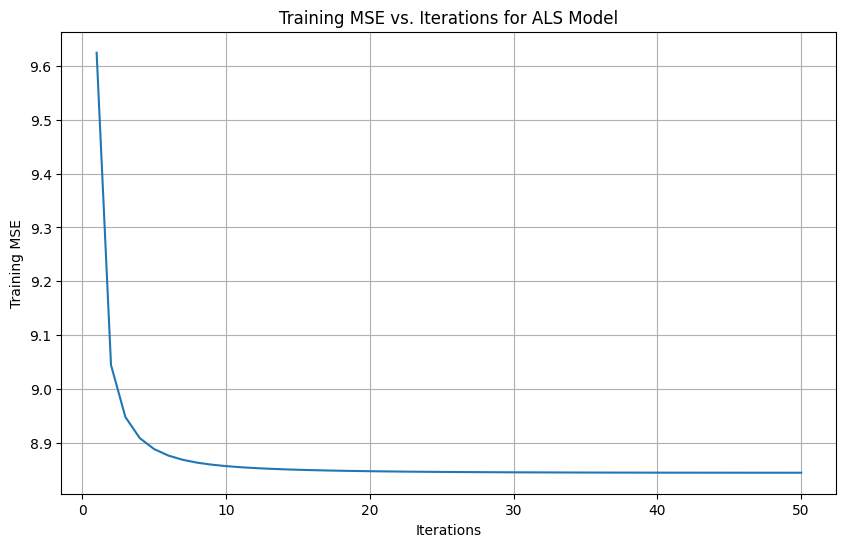

In [ ]:
import matplotlib.pyplot as plt

# Initialize the ALS model with verbose output for tracking progress (optional)
model = AlternatingLeastSquares(factors=50, regularization=0.1, iterations=1, use_gpu=False)

# Lists to store iteration and loss values
iterations = []
loss_values = []

# Manually train the model for a specified number of iterations
num_iterations_to_plot = 50  # Set the number of iterations you want to plot

for i in range(num_iterations_to_plot):
    # Perform one iteration of training
    model.fit(train_user_item_matrix)

    # Calculate the loss (e.g., mean squared error on the training data)
    # Note: Calculating the exact loss for ALS can be complex and computationally expensive.
    # A simpler approach is to calculate the MSE on the training set after each iteration.
    # This gives an indication of convergence, but is not the true ALS objective loss.

    # Get user and item factors
    user_factors = model.user_factors
    item_factors = model.item_factors

    # Calculate predicted ratings for the training set
    train_predictions = []
    for index, row in train_df.iterrows():
        user_id = int(row["userId"])
        movie_id = int(row["movieId"])
        if user_id < num_users and movie_id < num_movies:
             train_predictions.append(user_factors[user_id].dot(item_factors[movie_id]))


    # Calculate MSE for the current iteration
    mse = mean_squared_error(train_df['rating'], train_predictions)
    loss_values.append(mse)
    iterations.append(i + 1)
    print(f"Iteration {i+1}, Training MSE: {mse}")


# Plot the loss values
plt.figure(figsize=(10, 6))
plt.plot(iterations, loss_values)
plt.xlabel("Iterations")
plt.ylabel("Training MSE")
plt.title("Training MSE vs. Iterations for ALS Model")
plt.grid(True)
plt.show()

**Plot of loss values versus feature dimension 𝑛 for a constant number of iterations**

Training with factors = 10...


  0%|          | 0/50 [00:00<?, ?it/s]

Finished training with factors = 10, Final Training MSE: 9.985447961842407

Training with factors = 20...


  0%|          | 0/50 [00:00<?, ?it/s]

Finished training with factors = 20, Final Training MSE: 9.553166414926332

Training with factors = 30...


  0%|          | 0/50 [00:00<?, ?it/s]

Finished training with factors = 30, Final Training MSE: 9.261287319748376

Training with factors = 40...


  0%|          | 0/50 [00:00<?, ?it/s]

Finished training with factors = 40, Final Training MSE: 9.033158649621736

Training with factors = 50...


  0%|          | 0/50 [00:00<?, ?it/s]

Finished training with factors = 50, Final Training MSE: 8.84443204735853

Training with factors = 60...


  0%|          | 0/50 [00:00<?, ?it/s]

Finished training with factors = 60, Final Training MSE: 8.683625499654871

Training with factors = 70...


  0%|          | 0/50 [00:00<?, ?it/s]

Finished training with factors = 70, Final Training MSE: 8.545223569837663

Training with factors = 80...


  0%|          | 0/50 [00:00<?, ?it/s]

Finished training with factors = 80, Final Training MSE: 8.425454732719661

Training with factors = 90...


  0%|          | 0/50 [00:00<?, ?it/s]

Finished training with factors = 90, Final Training MSE: 8.320650658374793

Training with factors = 100...


  0%|          | 0/50 [00:00<?, ?it/s]

Finished training with factors = 100, Final Training MSE: 8.228958646563127

Training with factors = 110...


  0%|          | 0/50 [00:00<?, ?it/s]

Finished training with factors = 110, Final Training MSE: 8.14729692883746

Training with factors = 120...


  0%|          | 0/50 [00:00<?, ?it/s]

Finished training with factors = 120, Final Training MSE: 8.07445930611278

Training with factors = 130...


  0%|          | 0/50 [00:00<?, ?it/s]

Finished training with factors = 130, Final Training MSE: 8.009457655442501

Training with factors = 140...


  0%|          | 0/50 [00:00<?, ?it/s]

Finished training with factors = 140, Final Training MSE: 7.950812121283199

Training with factors = 150...


  0%|          | 0/50 [00:00<?, ?it/s]

Finished training with factors = 150, Final Training MSE: 7.898660734033492



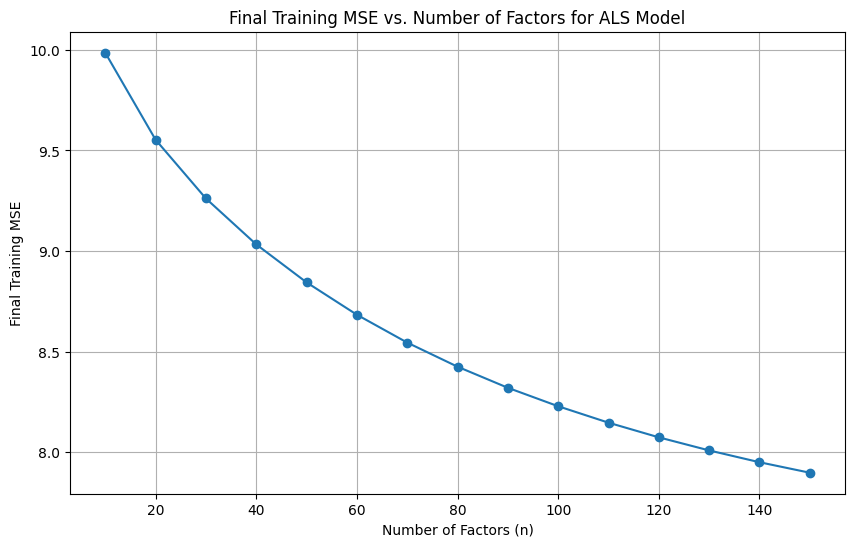

In [ ]:
# Experiment with different feature dimensions (factors)
factor_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140,150]  # Define a range of factors to test
constant_iterations = 50  # Set a constant number of iterations

# Lists to store factor values and corresponding final MSE
final_mse_values = []

for factors in factor_values:
    print(f"Training with factors = {factors}...")
    # Initialize and train the ALS model with the current number of factors
    model = AlternatingLeastSquares(factors=factors, regularization=0.1, iterations=constant_iterations, use_gpu=False)
    model.fit(train_user_item_matrix)

    # Calculate the final MSE on the training data after training
    user_factors = model.user_factors
    item_factors = model.item_factors

    train_predictions = []
    for index, row in train_df.iterrows():
        user_id = int(row["userId"])
        movie_id = int(row["movieId"])
        if user_id < num_users and movie_id < num_movies:
            train_predictions.append(user_factors[user_id].dot(item_factors[movie_id]))


    mse = mean_squared_error(train_df['rating'], train_predictions)
    final_mse_values.append(mse)
    print(f"Finished training with factors = {factors}, Final Training MSE: {mse}\n")


# Plot the final MSE values versus factors
plt.figure(figsize=(10, 6))
plt.plot(factor_values, final_mse_values, marker='o')
plt.xlabel("Number of Factors (n)")
plt.ylabel("Final Training MSE")
plt.title("Final Training MSE vs. Number of Factors for ALS Model")
plt.grid(True)
plt.show()